## Resumen del notebook

En este notebook se implementa una regresión logisitca para una clasficación binomial.

En este notebook se implementan redes neuronales con mas capas ocultas. Se pretede mejorar el rendimiento de los modelos anteriores al añadir mas parametros (debido a las capas añadidas). Se presentan los resultados para un modelo de 2 y 4 capas ocultas.



Al final del notebook se realiza una prueba del modelo entrenado con imagenes de lentes gravitacionales reales con forma de arco para analizar el desempeño ante estas imagenes. Los resultados detallados para cada modelo se encuentran mas adelante. 
 

**Información del data set utilizado:**

No. Imagenes **sin** lentes para TRAIN: 1700

No. Imagenes **con** lentes para TRAIN: 3783


No. Imagenes **sin** lentes para TEST: 1450

No. Imagenes **con** lentes para TEST: 2500


**Principales hiperparametros de entrenamiento en este notebook:**

Tamaño en pixeles de las imagenes de entrenamiento: 217x217x3 

Alpha (learning rate): 0.005

Numero de iteraciones durante el entrenamiento: 2000

**Desempeño de este modelo ante imagenes reales de lentes gravitacionales: MAL:** Realiza una mala clasificación en la mayoria de las imagenes reales. Se necesita mejorar el modelo en general y tratar de identificar por qué el rendimiento del modelo disminuyó. 

**Desempeño del modelo:**

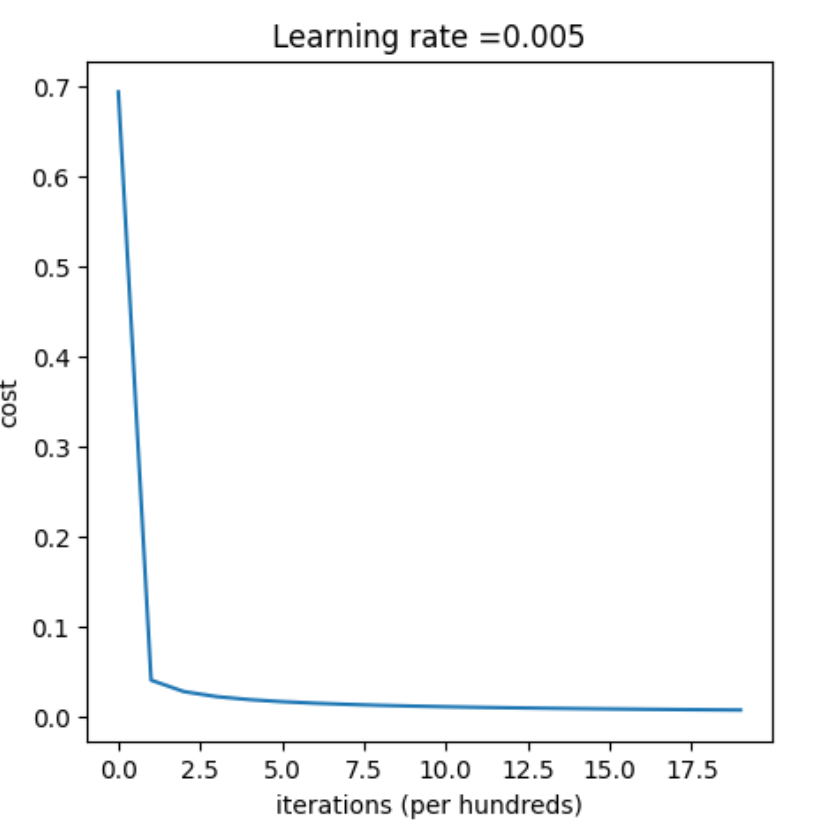

**Desempeño del modelo con diferentes valores de alpha (learning rate):**

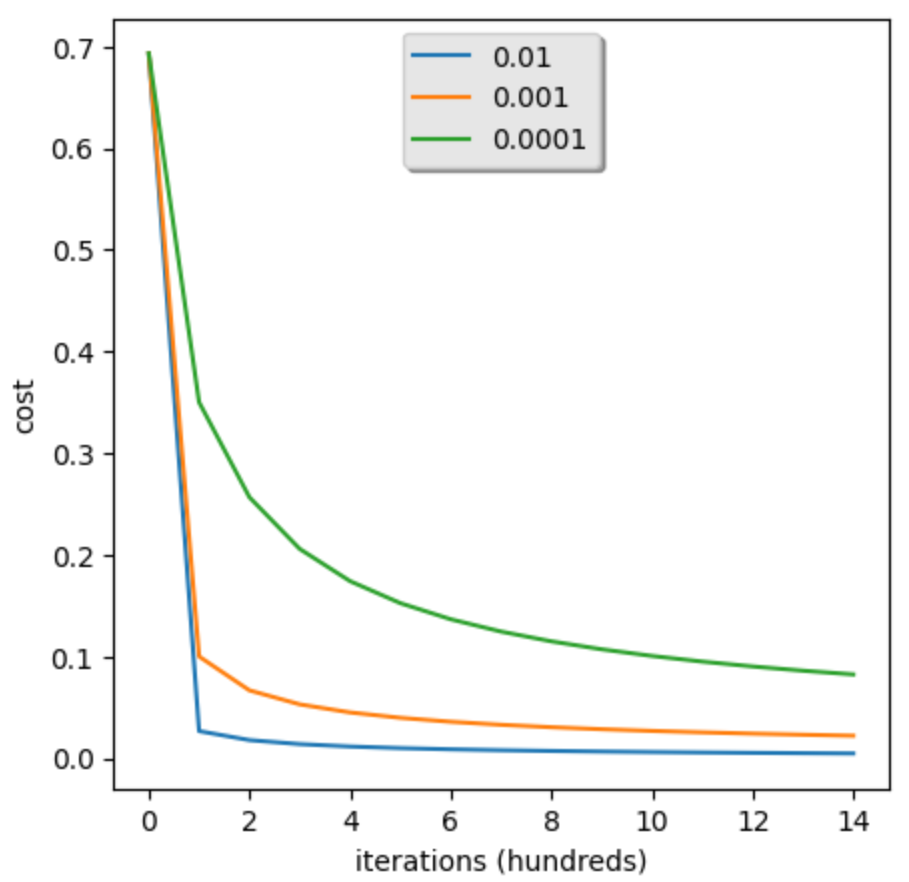

<a name='1'></a>
## Cargar librerias 

Primero cargamos las librerias necesarias para este notebook de clasificación binaria.

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
#####
import tensorflow as tf
from astroNN.datasets import galaxy10
import sklearn
from sklearn.model_selection import train_test_split
#import scipy.ndimage
import cv2
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data
import os
from scipy import ndimage

2022-11-29 17:52:43.173335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 17:52:47.484674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 17:52:47.484882: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 17:53:07.741290: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set


In [3]:
#tamaño de pixeles al que serán ajustadas las imagenes de entrenamiento y prueba
n_pixeles=64
dim = (n_pixeles, n_pixeles)

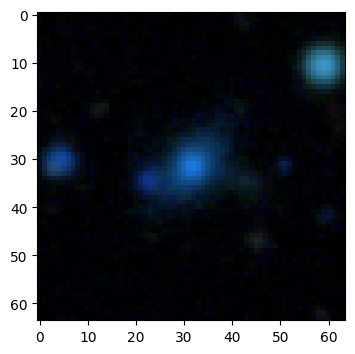

In [4]:
# Crear un solo arreglo de todas las imagenes dentro de las carpeta TRAIN
image1 = cv2.imread('/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/0_Smooth, in-between round.png')
image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
image2 = cv2.imread('/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/1000.png')
image2 = cv2.resize(image2, dim, interpolation = cv2.INTER_AREA) 


train_set_x_orig_2 = np.append(image1 , image1)
train_set_x_orig_2.shape

basepath = '/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/'

i = 0
with os.scandir(basepath) as entries:
    for entry in entries:
        if entry.is_file():
            #print(str(entry.name))
            if(i > 1):
                name = f'/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies/' + str(entry.name)
                image1 = cv2.imread(name)
                image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
                imaget = train_set_x_orig_2
                train_set_x_orig_2 = np.append(imaget , image1)
        i = i+1

basepath2 = '/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies_lens/'
        
with os.scandir(basepath2) as entries:
    for entry in entries:
        if entry.is_file():
            #print(str(entry.name))
            name = f'/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/train_galaxies_lens/' + str(entry.name)
            image1 = cv2.imread(name)
            image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
            imaget = train_set_x_orig_2
            train_set_x_orig_2 = np.append(imaget , image1)
      

p2 = train_set_x_orig_2.shape[0]/(n_pixeles*n_pixeles*3) 
r2 = int(p2)
plt.imshow(train_set_x_orig_2.reshape(r2, n_pixeles, n_pixeles, 3)[0])

# Crear un solo arreglo de todas las imagenes dentro de las carpeta TEST
image1 = cv2.imread('/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/0.png')
image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
image2 = cv2.imread('/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/0_Smooth, in-between round.png')
image2 = cv2.resize(image2, dim, interpolation = cv2.INTER_AREA) 

test_set_x_orig_2 = np.append(image1 , image1)
test_set_x_orig_2.shape

basepath = '/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/'

i = 0
with os.scandir(basepath) as entries:
    for entry in entries:
        if entry.is_file():
            #print(str(entry.name))
            if(i > 1):
                name = f'/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies/' + str(entry.name)
                image1 = cv2.imread(name)
                image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
                imaget = test_set_x_orig_2
                test_set_x_orig_2 = np.append(imaget , image1)
        i = i+1   
        
basepath2 = '/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies_lens/'
        
with os.scandir(basepath2) as entries:
    for entry in entries:
        if entry.is_file():
            #print(str(entry.name))
            name = f'/root/deep_learning/Neural_Networks_and_Deep_Learning/W2_A2/test_galaxies_lens/' + str(entry.name)
            image1 = cv2.imread(name)
            image1 = cv2.resize(image1, dim, interpolation = cv2.INTER_AREA) 
            imaget = test_set_x_orig_2
            test_set_x_orig_2 = np.append(imaget , image1)
        
p = test_set_x_orig_2.shape[0]/(n_pixeles*n_pixeles*3) 
r = int(p)
plt.imshow(test_set_x_orig_2.reshape(r, n_pixeles, n_pixeles, 3)[1])

In [16]:
train = train_set_x_orig_2.reshape(r2, n_pixeles, n_pixeles, 3)
train.shape

(17045, 64, 64, 3)

In [17]:
# para train
d1=8811 # sin lentes
d2=8233 #con lentes

hola = np.zeros((1, d1 + 1)) 
bye = np.zeros((1, d2)) + 1
c = np.append(hola, bye)
c_train = c.reshape(1, d1+d2 +1)
c_train.shape

(1, 17045)

In [18]:
test = test_set_x_orig_2.reshape(r, n_pixeles, n_pixeles, 3)
test.shape

(7478, 64, 64, 3)

In [19]:
# para test
d1=3272 #sin lentes
d2=4206 #con lentes

hola = np.zeros((1, d1))
bye = np.zeros((1, d2)) + 1
c = np.append(hola, bye)
c_test = c.reshape(1, d1+d2)
c_test.shape

(1, 7478)

<a name='2'></a>
## 2 - Load and Process the Dataset

You'll be using the same "Cat vs non-Cat" dataset as in "Logistic Regression as a Neural Network" (Assignment 2). The model you built back then had 70% test accuracy on classifying cat vs non-cat images. Hopefully, your new model will perform even better!

**Problem Statement**: You are given a dataset ("data.h5") containing:
    - a training set of `m_train` images labelled as cat (1) or non-cat (0)
    - a test set of `m_test` images labelled as cat and non-cat
    - each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [20]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [21]:
classes

array([b'non-cat', b'cat'], dtype='|S7')

In [22]:
# Loading the data (LENS / NO_LENS)
classes2 = classes
classes2[0] = b'NO_LENS'
classes2[1] = b'LENS'


train_x_orig = train
train_y = c_train
test_x_orig = test
test_y = c_test
classes = classes2

In [23]:
train_x_orig.shape

(17045, 64, 64, 3)

In [24]:
train_y.shape

(1, 17045)

In [25]:
test_x_orig.shape

(7478, 64, 64, 3)

In [26]:
test_y.shape

(1, 7478)

In [27]:
classes[np.squeeze(train_y[:, 0].astype(int))].decode("utf-8")

'NO_LENS'

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to check out other images. 

y = 0.0. It's a NO_LENS picture.


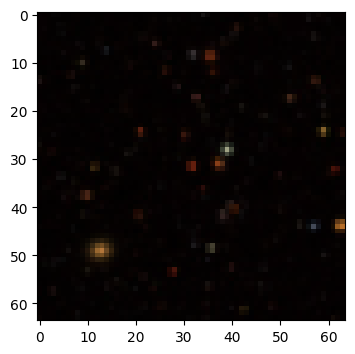

In [29]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index].astype(int)].decode("utf-8") +  " picture.")

In [30]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 17045
Number of testing examples: 7478
Each image is of size: (64, 64, 3)
train_x_orig shape: (17045, 64, 64, 3)
train_y shape: (1, 17045)
test_x_orig shape: (7478, 64, 64, 3)
test_y shape: (1, 7478)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [31]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 17045)
test_x's shape: (12288, 7478)


**Note**:
$12,288$ equals $64 \times 64 \times 3$, which is the size of one reshaped image vector.

<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Now that you're familiar with the dataset, it's time to build a deep neural network to distinguish cat images from non-cat images!

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, you'll compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 3</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. If it is greater than 0.5, classify it as a cat.

<a name='3-3'></a>
### 3.3 - General Methodology

As usual, you'll follow the Deep Learning methodology to build the model:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

Now go ahead and implement those two models!

<a name='4'></a>
## 4 - Two-layer Neural Network

<a name='ex-1'></a>
### Exercise 1 - two_layer_model 

Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [33]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [34]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        # YOUR CODE STARTS HERE
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = 'relu')
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = 'sigmoid')
        
        # YOUR CODE ENDS HERE
        
        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(A2, Y)
        
        # YOUR CODE ENDS HERE
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        # YOUR CODE STARTS HERE
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, 'sigmoid')
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, 'relu')
        
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [35]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6930453387431553
Cost after first iteration: 0.6930510839483969
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 2: 0.6524135179683452
 All tests passed.


**Expected output:**

```
cost after iteration 1 must be around 0.69
```

<a name='4-1'></a>
### 4.1 - Train the model 

If your code passed the previous cell, run the cell below to train your parameters. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

Cost after iteration 0: 0.6930510839483969
Cost after iteration 100: 0.6920470218412306
Cost after iteration 200: 0.6836460703942604
Cost after iteration 300: 0.6278136911728605
Cost after iteration 400: 0.5486836470821652
Cost after iteration 500: 0.4895593976831243
Cost after iteration 600: 0.4368049178068876
Cost after iteration 700: 0.3934023355687213
Cost after iteration 800: 0.3622682200370837
Cost after iteration 900: 0.339683657396218
Cost after iteration 1000: 0.3219854763460692
Cost after iteration 1100: 0.30723591155918323
Cost after iteration 1200: 0.2944790862619531
Cost after iteration 1300: 0.28325133194682
Cost after iteration 1400: 0.27326029941079366
Cost after iteration 1500: 0.2643110437702997
Cost after iteration 1600: 0.25627263608989725
Cost after iteration 1700: 0.2490812611761678
Cost after iteration 1800: 0.242648869368351
Cost after iteration 1900: 0.23687825174825372
Cost after iteration 2000: 0.2316376286889422
Cost after iteration 2100: 0.22688082675609567

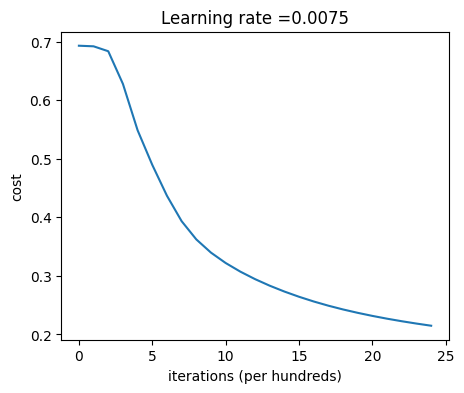

In [36]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.04421498215868956 </td>
    </tr>
</table>

**Nice!** You successfully trained the model. Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to classify images from the dataset. To see your predictions on the training and test sets, run the cell below.

In [37]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9333528894103842


**Expected Output**:
<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.9999999999999998 </td>
    </tr>
</table>

In [38]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.8188018186680932


**Expected Output**:

<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.72 </td>
    </tr>
</table>

### Congratulations! It seems that your 2-layer neural network has better performance (72%) than the logistic regression implementation (70%, assignment week 2). Let's see if you can do even better with an $L$-layer model.

**Note**: You may notice that running the model on fewer iterations (say 1500) gives better accuracy on the test set. This is called "early stopping" and you'll hear more about it in the next course. Early stopping is a way to prevent overfitting. 

<a name='5'></a>
## 5 - L-layer Neural Network

<a name='ex-2'></a>
### Exercise 2 - L_layer_model 

Use the helper functions you implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [39]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [51]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.009, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)
        
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL, Y)
        
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)
        
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [41]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

L_layer_model_test(L_layer_model)

Cost after iteration 0: 0.7143974258893059
Cost after first iteration: 0.7143974258893059
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 1: 0.7070709008912569
Cost after iteration 2: 0.7063462654190897
 All tests passed.


<a name='5-1'></a>
### 5.1 - Train the model 

If your code passed the previous cell, run the cell below to train your model as a 4-layer neural network. 

- The cost should decrease on every iteration. 

- It may take up to 5 minutes to run 2500 iterations. 

In [42]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7143974258893059
Cost after iteration 100: 0.6113485242366965
Cost after iteration 200: 0.5675309239877526
Cost after iteration 300: 0.5335427815320857
Cost after iteration 400: 0.5017007823275326
Cost after iteration 500: 0.47188260519817365
Cost after iteration 600: 0.4432721253280212
Cost after iteration 700: 0.4160913457901541
Cost after iteration 800: 0.3913022149553329
Cost after iteration 900: 0.3689269271665712
Cost after iteration 1000: 0.3487300911140626
Cost after iteration 1100: 0.33053375873622204
Cost after iteration 1200: 0.31428086948434847
Cost after iteration 1300: 0.299722132238248
Cost after iteration 1400: 0.2865638409482159
Cost after iteration 1500: 0.27460805235308033
Cost after iteration 1600: 0.2637105416469065
Cost after iteration 1700: 0.25371913175653515
Cost after iteration 1800: 0.2445548408249969
Cost after iteration 1900: 0.23613115534146736
Cost after iteration 2000: 0.2283618229315743
Cost after iteration 2100: 0.221165980521

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.088439 </td>
    </tr>
</table>

In [43]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9571135230272806


**Expected Output**:

<table>
    <tr>
    <td>
        <b>Train Accuracy</b>
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [44]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8201390746188822


**Expected Output**:

<table> 
    <tr>
        <td> <b>Test Accuracy</b></td>
        <td> 0.8 </td>
    </tr>
</table>

## Triying with a higher number of iterations

In [ ]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 10000, print_cost = True)

Cost after iteration 0: 0.7143974258893059
Cost after iteration 100: 0.6007553858143729
Cost after iteration 200: 0.5536909322341106
Cost after iteration 300: 0.5141021175945742
Cost after iteration 400: 0.4777578568450897
Cost after iteration 500: 0.4432853673420251
Cost after iteration 600: 0.41100101546720547
Cost after iteration 700: 0.38213549319724993
Cost after iteration 800: 0.35659674459289425
Cost after iteration 900: 0.3340589045146267
Cost after iteration 1000: 0.31431496205588444
Cost after iteration 1100: 0.297021964076816
Cost after iteration 1200: 0.2816835949453725
Cost after iteration 1300: 0.2679999853390438
Cost after iteration 1400: 0.2556875123982255
Cost after iteration 1500: 0.24458667940060744
Cost after iteration 1600: 0.23454925283575606
Cost after iteration 1700: 0.22544693311585046
Cost after iteration 1800: 0.2171259983738957
Cost after iteration 1900: 0.20947416928653462
Cost after iteration 2000: 0.20238363694206743
Cost after iteration 2100: 0.195858780

In [ ]:
pred_train = predict(train_x, train_y, parameters)

In [ ]:
pred_test = predict(test_x, test_y, parameters)

### Congrats! It seems that your 4-layer neural network has better performance (80%) than your 2-layer neural network (72%) on the same test set. 

This is pretty good performance for this task. Nice job! 

In the next course on "Improving deep neural networks," you'll be able to obtain even higher accuracy by systematically searching for better hyperparameters: learning_rate, layers_dims, or num_iterations, for example.  

<a name='6'></a>
##  6 - Results Analysis

First, take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

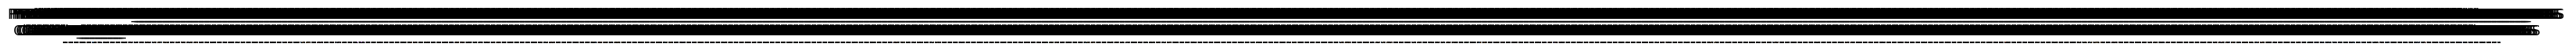

In [48]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### Congratulations on finishing this assignment! 

You just built and trained a deep L-layer neural network, and applied it in order to distinguish cats from non-cats, a very serious and important task in deep learning. ;) 

By now, you've also completed all the assignments for Course 1 in the Deep Learning Specialization. Amazing work! If you'd like to test out how closely you resemble a cat yourself, there's an optional ungraded exercise below, where you can test your own image. 

Great work and hope to see you in the next course! 

<a name='7'></a>
## 7 - Test with your own image (optional/ungraded exercise) ##

From this point, if you so choose, you can use your own image to test  the output of your model. To do that follow these steps:

1. Click on "File" in the upper bar of this notebook, then click "Open" to go on your Coursera Hub.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Change your image's name in the following code
4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "NO_LENS" picture.


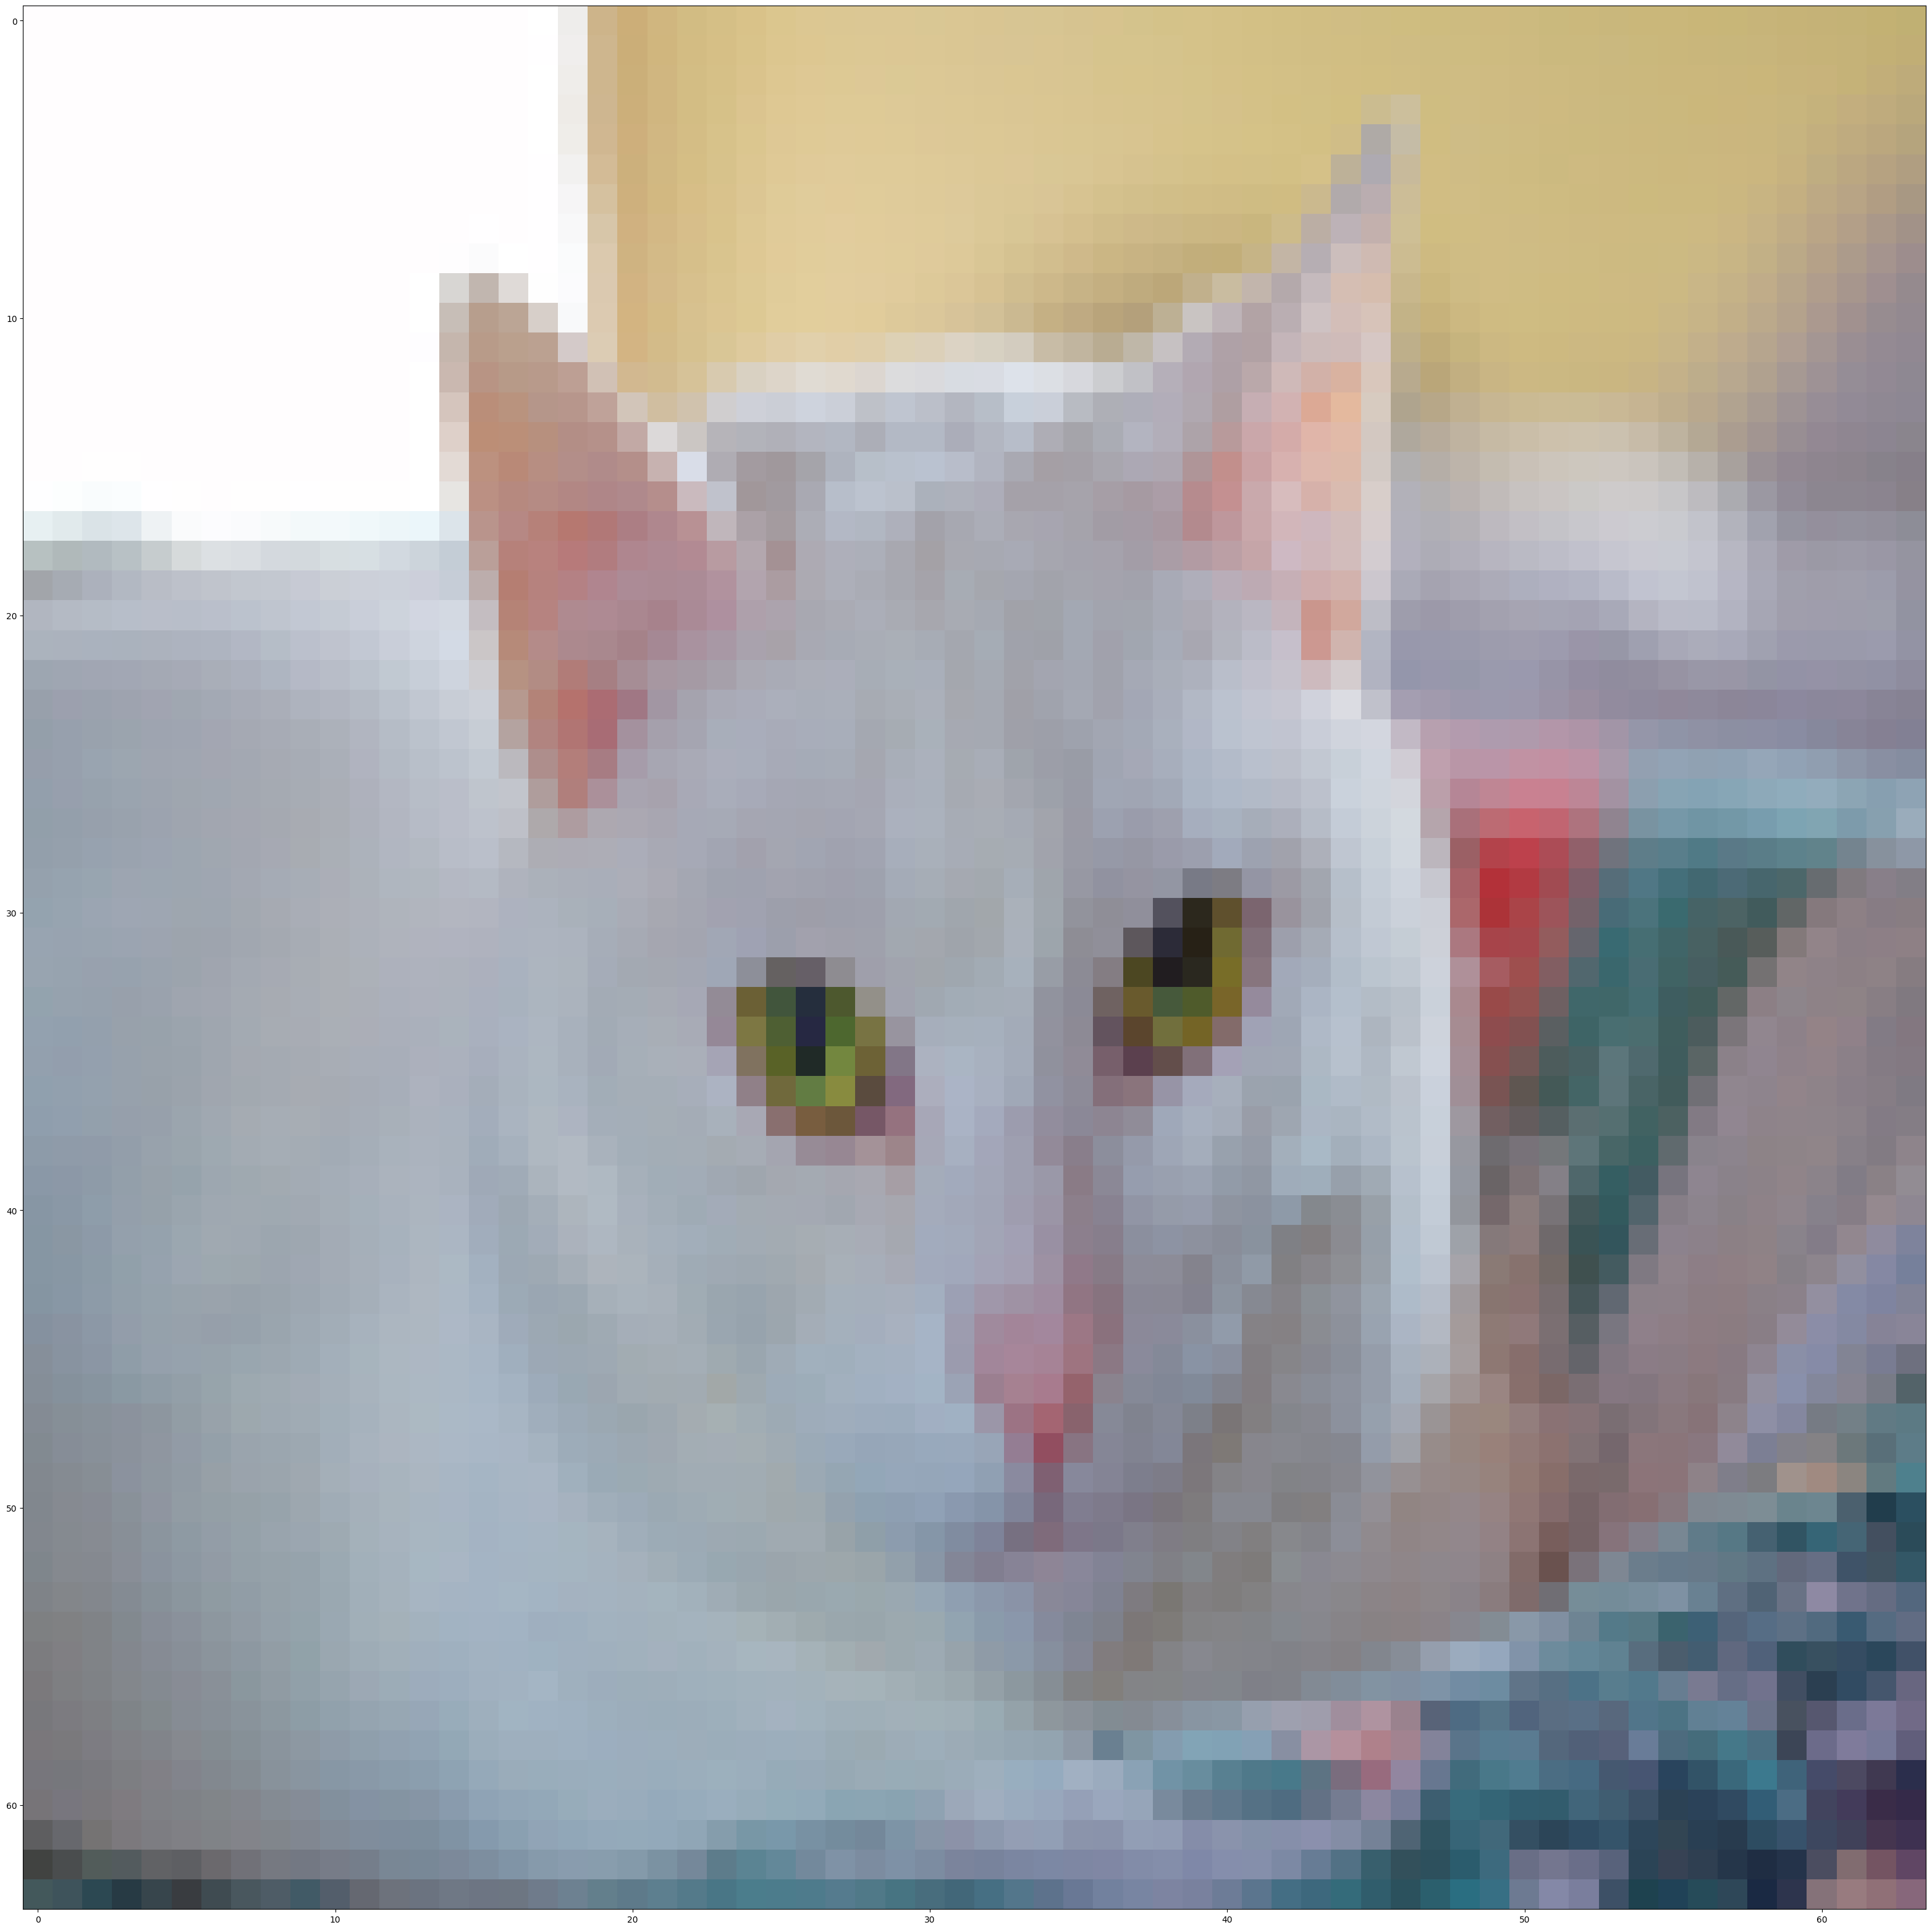

In [49]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

**References**:

- for auto-reloading external module: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython